# __CNN__

We decide to use CNN(convolutional neural networks) for the task of guitar tablature estimation. The previous work of Andrew Wiggins and Youngmoo Kim showed that CNNs have shown promise for translating guitar audios to tabs, and the use of CNNs has also been explored for various other tasks within music information retrieval such as musical tempo estimation, key classification, singing voice detection, and instrument classification. It is proven that CNN is a powerful tool for the purpose of our study.

## __Import libraries__

In [1]:
# Import required packages 

#various
import datetime
import pathlib
import IPython.display as display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image
import warnings


#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

#tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

#keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

# Load the TensorBoard notebook extension
%load_ext tensorboard

RSEED = 42

warnings.filterwarnings('ignore')

In [2]:
#Clear any logs from previous runs
!rm -rf ./logs/

In [3]:
# Check for Tensorflow version
print(tf.__version__)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

2.8.0


## __"Write Python Script" function__

`%%write_and_run image_modeling.py` is the call of the register cell magic from below in 'w' mode (default). It writes the imports at the beginning of the `image_modeling.py`.

In [4]:
'''# Let's make some dark cell magic. Why not!

from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
        print("Appended to file ", file)
    else:
        print('Written to file:', file)
    with open(file, mode) as f:
        f.write(cell.format(**globals()))        
    get_ipython().run_cell(cell)'''

'# Let\'s make some dark cell magic. Why not!\n\nfrom IPython.core.magic import register_cell_magic\n\n@register_cell_magic\ndef write_and_run(line, cell):\n    argz = line.split()\n    file = argz[-1]\n    mode = \'w\'\n    if len(argz) == 2 and argz[0] == \'-a\':\n        mode = \'a\'\n        print("Appended to file ", file)\n    else:\n        print(\'Written to file:\', file)\n    with open(file, mode) as f:\n        f.write(cell.format(**globals()))        \n    get_ipython().run_cell(cell)'

## __Define Input Shapes__

In [5]:
#Definition of all our constants we use for our model 

FRAME_HEIGHT = 192
FRAME_WIDTH = 9
N_CLASSES = 21
N_STRINGS = 6
BATCH_SIZE = 128
EPOCHS = 8

TRAIN_PATH = 'our trainset path.csv'
VAL_PATH = 'our evalset path.csv'
TEST_PATH = 'our testset path.csv'

#TRAINING_SIZE = !wc -l < flowers_train.csv
#TRAINING_STEPS = int(TRAINING_SIZE[0]) // BATCH_SIZE




Using Tensorboard to monitor our results:

In [6]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 5809), started 1 day, 19:12:21 ago. (Use '!kill 5809' to kill it.)

## __Load Data__

In [7]:
#we load the data from our output folder from preprocessing
OUTPUT_PATH = "../data/output/"
audio_file = "02_BN1-129-Eb_solo_hex_cln.wav"

IMAGES = np.load(OUTPUT_PATH+'/'+audio_file.split('.')[0]+'_data.npz')
annots = np.load(OUTPUT_PATH+'/'+audio_file.split('.')[0]+'_labels.npz')

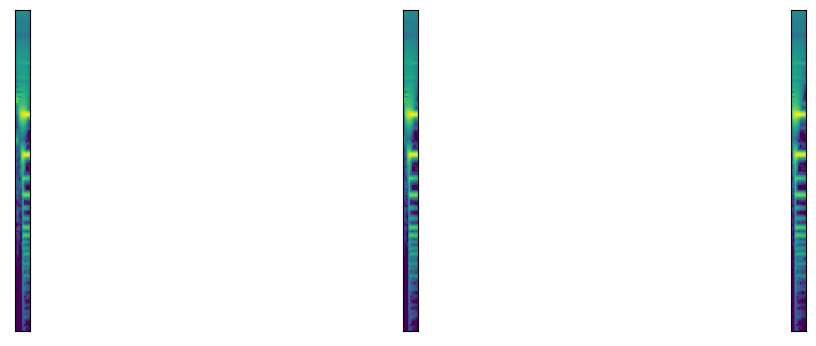

In [8]:
#show some spectrograms of our data frames
plt.figure(figsize=(500,500))
for i in range(60,63):
    plt.subplot(100,100,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(IMAGES['arr_0'][i])

In [9]:
#show the belonging annotations for this three images
print(annots['arr_0'][60:63])

[[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

## __Do train & test split__

In [10]:
#First we have to split our dataset into train and test set. We use 70% for the train set and 30% for the test set.
train_images, test_images, train_annots, test_annots = train_test_split(IMAGES['arr_0'], annots['arr_0'], test_size= 0.3, random_state= RSEED )

In [11]:
#Because we need also a validation set we split once more. We take this time 10% of the train set for 
#the validation set and take the rest for training.
train_images, validate_images,train_annots,validate_annots = train_test_split(train_images,train_annots, test_size = 0.1,random_state = RSEED)

In [12]:
#let's have a look on the different shapes of our sets
print(train_images.shape)
print(test_images.shape)
print(validate_images.shape)
print(train_annots.shape)
print(test_annots.shape)
print(validate_annots.shape)


(605, 192, 9)
(289, 192, 9)
(68, 192, 9)
(605, 6, 21)
(289, 6, 21)
(68, 6, 21)


## __Building our CNN Model__

In [13]:
#the function of our cnn model
'''what it takes:
- a picture with a certain frame height(192pixel) and a frame width(9 pixel)
- only one color channel, therefore as a grayscale image

what it deliver:

An array with the size 6x21. This is representing the 6 different strings of a guitar and 19 different 
frets of the guitar. The other 2 of the 21 entries represent, if a string is played or not played.

The different layers we used you can easily extract from below.
'''

def cnn_swizzle_model():       
        swizzle_model = tf.keras.Sequential()
        swizzle_model.add(tf.keras.layers.InputLayer(input_shape=[FRAME_HEIGHT, FRAME_WIDTH, 1]))
        swizzle_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3),activation='relu'))
        swizzle_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        swizzle_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        swizzle_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        swizzle_model.add(tf.keras.layers.Dropout(0.25))   
        swizzle_model.add(tf.keras.layers.Flatten())
        swizzle_model.add(tf.keras.layers.Dense(128, activation='relu'))
        swizzle_model.add(tf.keras.layers.Dropout(0.5))
        swizzle_model.add(tf.keras.layers.Dense(126, activation='relu'))
        swizzle_model.add(tf.keras.layers.Dense(N_CLASSES * N_STRINGS)) # no activation
        swizzle_model.add(tf.keras.layers.Reshape((N_STRINGS, N_CLASSES)))
        swizzle_model.add(tf.keras.layers.Activation('softmax'))
        return swizzle_model

In [14]:
#this is our swizzle model
swizzle_model = cnn_swizzle_model()


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-01-05 10:50:50.346845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-05 10:50:50.347177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
#let's have a look on the model summary to see the different layers and their shapes
#we have 3 dimensions in the beginning, then flatten to 1 Dimension for the dense layers and after them
#create the end shape representing the guitar with 6 strings and 21 frets
swizzle_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 7, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 188, 5, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 186, 3, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 93, 1, 64)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 93, 1, 64)         0         
                                                                 
 flatten (Flatten)           (None, 5952)              0         
                                                        

## Define model metrics for the cnn

In [16]:
'''
Metric: For our model we will use the accuracy metric, because we want to have o good overall 
prediction of our model. Besides that, for us every tone has the same importance so all classes
have the same importance.

Optimizer: As an optimizer we take the adam optimizer, which is fast enough to handle our data 
in a short time

Loss function: For the loss function we used categorical crossentropy because we have multiple classes or labels
with soft probabilities like [0.5, 0.3, 0.2] and also have a shape like a one-hot-encoded array.
'''
metrics =['accuracy']

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#we keep this for later, to test out.
#RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) 
#adadelta

loss='categorical_crossentropy'



In [17]:
swizzle_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

## Use annealer to decrease learning rate after given epochs

In [18]:
# Set a learning rate annealer
'''
With the ReduceLROnPlateau function from Keras.callbacks, 
we choose to reduce the Learning Rate by half if the accuracy is not improved after 3 epochs.
'''
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)

## __Train CNN__

In [19]:
#Create folder for model 
'''This function takes the path of a new folder and create a new one. 
If the folder already exists, it will pass.'''
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)

my_makedirs('../data/model')

In [20]:

csv_logger = tf.keras.callbacks.CSVLogger('../data/model/metrics.csv')

In [21]:
#for the training we fit our model and use the batch size and epochs from our constants
history = swizzle_model.fit( train_images,
                             train_annots,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             verbose=1,
                             validation_data=(validate_images,validate_annots),
                             callbacks=[learning_rate_reduction,csv_logger],
)

swizzle_model_metrics = pd.read_csv('../data/model/metrics.csv')
print(swizzle_model_metrics.to_markdown())

Epoch 1/8


2023-01-05 10:50:50.689147: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 10:50:51.035622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 100ms/step - loss: 4.1446 - accuracy: 0.3083 - val_loss: 1.0487 - val_accuracy: 0.8431 - lr: 0.0010
Epoch 2/8
2/5 [===========>..................] - ETA: 0s - loss: 1.3114 - accuracy: 0.6543

2023-01-05 10:50:51.684421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 55ms/step - loss: 1.0366 - accuracy: 0.7331 - val_loss: 0.5173 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 3/8
5/5 [==============================] - 0s 47ms/step - loss: 0.5845 - accuracy: 0.8680 - val_loss: 0.3963 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 4/8
5/5 [==============================] - 0s 49ms/step - loss: 0.4138 - accuracy: 0.9121 - val_loss: 0.3735 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 5/8
5/5 [==============================] - ETA: 0s - loss: 0.3747 - accuracy: 0.9088
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5/5 [==============================] - 0s 47ms/step - loss: 0.3747 - accuracy: 0.9088 - val_loss: 0.3436 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 6/8
5/5 [==============================] - 0s 46ms/step - loss: 0.3403 - accuracy: 0.9121 - val_loss: 0.3281 - val_accuracy: 0.9069 - lr: 5.0000e-04
Epoch 7/8
5/5 [==============================] - 0s 46ms/step - loss: 0.3268 - accuracy: 0.916

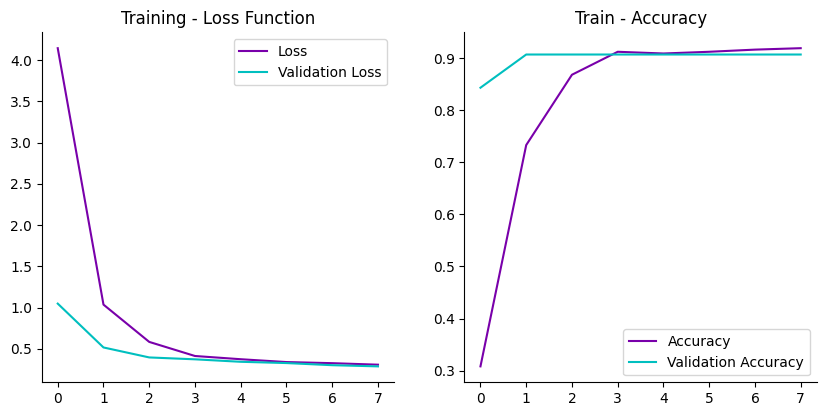

In [22]:
#show plots for our loss function and the accurancy
plt.figure(figsize=(10, 10))


ax = plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss', color= '#7900AA')
plt.plot(history.history['val_loss'], label='Validation Loss', color = 'c')
plt.legend()
plt.title('Training - Loss Function')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2 = plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy', color = '#7900AA')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color = 'c')
plt.legend()
plt.title('Train - Accuracy')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)


In [23]:
#print results of our swizzle model metrics for training
score = swizzle_model.evaluate(test_images,test_annots,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 0.2254
Test Accuracy : 0.9245


In [24]:
#the prediction of our model will show us an array with the strings played in the
# belonging frame
output = swizzle_model.predict(test_images)

2023-01-05 10:50:53.865250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [25]:
#we can have look on the output arrays. We rounded them to have a better overview. 
#Thats the first entry with a size of 6 by 21.
print(output.shape)
print(np.round(output[:1][0],2))


(289, 6, 21)
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  ]
 [0.97 0.   0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  ]
 [0.43 0.   0.   0.   0.   0.   0.16 0.33 0.   0.05 0.01 0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  ]
 [0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  ]
 [0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  ]]


In [26]:
# Save the entire model as a SavedModel.
swizzle_model.save('../data/model/swizzle_model')

loaded_swizzle_model = keras.models.load_model("../data/model/swizzle_model")

2023-01-05 10:50:54.236729: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../data/model/swizzle_model/assets


In [27]:
# Save and load the model output
np.save("../data/model/model_output.npy", output, allow_pickle=True, fix_imports=True)

#np.load("../data/model/model_output.npy")


In [28]:
'''
next:
- we plan an error analysis

'''

'\nnext:\n- we plan an error analysis\n\n'

In [29]:
#mcm = multilabel_confusion_matrix(test_annots, output)